In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# 1) Загрузка и базовая очистка
df = pd.read_csv('phones.csv')
df['disk'] = df['disk'].astype(str).str.replace(r'[^0-9\.]', '', regex=True)
df['disk'] = pd.to_numeric(df['disk'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
current_year = pd.Timestamp.now().year
df['age'] = current_year - df['year']
df = df[['disk', 'os', 'age', 'price']].dropna().reset_index(drop=True)

In [3]:
# 2) Превратим continuous target (price) в категории (например 3 квантиля)
# Можно менять на pd.cut с фиксированными порогами, или на количество классов
df['price_cat'] = pd.qcut(df['price'], q=3, labels=['low','medium','high'])

In [4]:
# 3) Формируем X и y (не включаем price в признаки!)
X = df[['disk', 'os', 'age']]
y = df['price_cat']

In [5]:
# 4) Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,   # сохраняем пропорции классов
                                                    random_state=42)

In [6]:
# 5) Предобработка: числовые и категориальные трансформеры
numeric_features = ['disk', 'age']
numeric_transformer = StandardScaler()

categorical_features = ['os']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# 6) Pipeline с классификатором (пример: RandomForest)
clf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [8]:
# 7) Обучение
clf.fit(X_train, y_train)

,steps,"[('preproc', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
# 8) Оценка на тесте
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9

Classification report:
               precision    recall  f1-score   support

        high       0.88      1.00      0.93         7
         low       1.00      0.83      0.91         6
      medium       0.86      0.86      0.86         7

    accuracy                           0.90        20
   macro avg       0.91      0.90      0.90        20
weighted avg       0.91      0.90      0.90        20



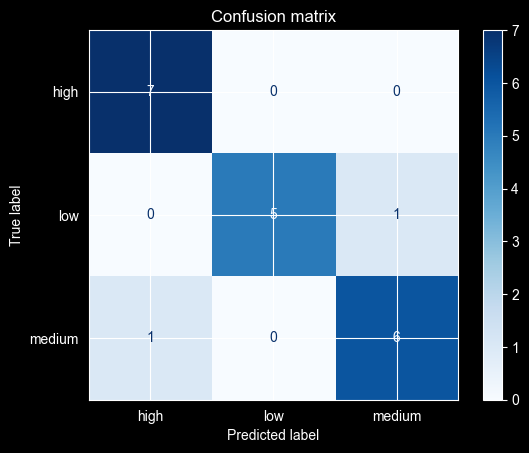

In [10]:
# 9) Confusion matrix (визуализация)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion matrix")
plt.show()

In [11]:
# 10) Пример использования: предсказание и вероятности
new_samples = pd.DataFrame([
    {'disk': 64, 'os': 'Android', 'age': 3},
    {'disk': 512, 'os': 'iOS', 'age': 1}
])
pred_classes = clf.predict(new_samples)
pred_proba = clf.predict_proba(new_samples)  # вероятности по классам
print("Новые объекты:\n", new_samples)
print("Предсказанные классы:", pred_classes)
print("Вероятности:\n", pd.DataFrame(pred_proba, columns=clf.classes_))

Новые объекты:
    disk       os  age
0    64  Android    3
1   512      iOS    1
Предсказанные классы: ['high' 'high']
Вероятности:
        high  low    medium
0  0.616476  0.0  0.383524
1  1.000000  0.0  0.000000


In [12]:
# 11) Сохранение модели
joblib.dump(clf, 'phone_price_classifier.joblib')
print("Модель сохранена: phone_price_classifier.joblib")

Модель сохранена: phone_price_classifier.joblib
